# A Review of [WILDS: A Benchmark of in-the-Wild Distribution Shifts](https://arxiv.org/pdf/2012.07421.pdf)

# The framework for final deliverables

## Problem statement

> What is the problem the paper aims to solve?

The paper observes the fact that distribution shifts occur in real-world datasets, and the authors aim to provide a set of example datasets against which algorithms can be evaluated for the purpose of improving performance when distribution shifts are present. The two types of distribution shifts the authors focus on in this paper are: domain generalization, where the test data is related but distinct from the train data, and subpopulation shift, where the test data is from a specific subpopulation that's present but underrepresented in the train data.

## Context/scope

> Why is this problem important or interesting?

Distribution shifts are ubiquitous in real-world applications, but ML research mostly focuses on contrived, cleanly-defined datasets. The the authors worry that the messiness of real-world data is a blind spot in academic research and therefore algorithms and methods must be re-evaluated in the lens of real-world data. The datasets the authors chose are specifically curated to maximize realism and diversity of application areas and characteristics.

## Existing work

> What has been done in literature?

The authors point to several examples of older, smaller datasets that have been used in the past but have fallen out of favor since modern models need more training data to be effective:

1. part-of speech tagging (Marcus et al., 1993)
2. sentiment analysis (Blitzer et al., 2007)
3. land cover classification (Bruzzone and Marconcini, 2009)
4. object recognition (Saenko et al., 2010)
5. flow cytometry (Blanchard et al., 2011)

They also give examples of researchers applying synthetic transformations in order to simulate shifts:

1. ImageNet-C (Hendrycks and Dietterich, 2019), which corrupts images with noise
2. the Backgrounds Challenge (Xiao et al., 2020)
3. Waterbirds (Sagawa et al., 2020a), which alter image backgrounds
4. Colored MNIST (Arjovsky et al., 2019), which changes the 6 colors of MNIST digits

Similarly, there are examples of using intentional data splits, or a combination of different, related datasets:

1. generalizing to photos solely from cartoons and other stylized images in PACS (Li et al., 2017a)
2. generalizing to objects at different scales solely from a single scale in DeepFashion Remixed (Hendrycks et al., 2020b)
3. Using training and test sets with disjoint subclasses in BREEDS (Santurkar et al., 2020)
4. Using similar datasets (Hendrycks and Dietterich, 2019)

## Contribution

> What is gap in literature that the paper is trying to fill? What is the unique contribution?

All of the above-listed examples are good testbeds for isolated experimentation, but in the WILDS paper the authors aim to evaluate whether algorithms proposed in these other papers are generally robust or simply robust to the specific testing conditions they were developed against.

## Technical content (high level)

> What are the high level ideas behind their technical contribution?

In this paper the authors apply a set of known "robust" algorithms to the real-world datasets presented in this paper and compare the algorithms' performance to a baseline to evaluate their effectiveness at minimizing the datasets' known distribution shifts' effects.

## Technical content (details)

> Highlight (not copy and paste entire sections) the relevant details that are important to focus on (e.g. if there's a model, define it; if there is a theorem, state it and explain why it's important, etc).

### Datasets

#### Domain Generalization Datasets:

* IWildCam2020: Species Classification Across Different Camera Traps
* Camelyon17: Tumor Identification Across Different Hospitals
* RxRx1: Genetic Perturbation Classification Across Experimental Batches
* OGB-MolPCBA: Molecular Property Prediction Across Different Scaffolds
* GlobalWheat: Wheat Head Detection Across Regions of the World

#### Subpopulation Shift Datasets:

* CivilComments: Toxicity Classification Across Demographic Identities

#### Hybrid Datasets (contain both Domain Generalization and Subpopulation Shift):

* FMoW: Land Use Classification Across Different Regions and Years
* PovertyMap: Poverty Mapping Across Different Countries
* Amazon: Sentiment Classification Across Different Users
* Py150: Code Completion Across Different Codebases

### Performance Drop Measurement Methodology

Train models via empirical risk minimization (ERM) and measure the difference between out-of-distribution and in-distribution performance. Then, train the same model via some other "robust" algorithm (listed below) and compare the difference between out-of-distribution and in-distribution performance.

Where feasible, the authors measured in-distribution performance on $p_{test}$. However, that was not always possible with every dataset where the test set may be significantly more difficult to train on than the training set. Therefore there are 5 different in-distribution settings the WILDS package provides, each of which has its own pros and cons, and which one is appropriate for a given dataset is decided on a case-by-case basis. In-distribution performance can be evaluated via:

* Test-to-test (train on $p_{test}$, test on $p_{test}$)
* Mixed-to-test (train on a mixture of $p_{train}$ and $p_{test}$, test on $p_{test}$)
* Train-to-train (train on $p_{train}$, evluate on $p_{train}$)
* Average (report average instead of worst-case performance)
* Random split (train and evaluate on an i.i.d. split)

### Model Selection

Standard model architectures for each dataset:

* ResNet and DenseNet for images (He et al., 2016; Huang et al., 2017)
* DistilBERT for text (Sanh et al., 2019)
* Graph Isomorphism Network (GIN) for graphs (Xu et al., 2018)
* Faster-RCNN (Ren et al., 2015) for detection

### Baseline Algorithms

#### Domain Generalization

* CORAL (Sun and Saenko, 2016)
* IRM (Arjovsky et al., 2019)

#### Subpopulation Shift

* Group DRO (Hu et al., 2018; Sagawa et al., 2020a)

## Technical content (details) (Jim, in progress)

## 1. The Out-of-Distribution (OOD) problem settings

We first define the out-of-distribution (OOD) generalisation problem. The original WILDS paper focus specifically on *supervised learning*, and in three situations -- domain genralisation, subpopulation shift, and the hybrid setting that involves both domain generalisation and subpopulation shift – it is hard to isolate one effect from the other.

A model is defined such as:

$$
f_{\theta}: X \rightarrow Y
$$

The model maps features $X$ to result $Y$; we seek to learn parameters $\theta$.

In the supervised learning settings, a loss function measures the distance between model output and ground truth. We define such loss as:

$$
\ell: (f_{\theta}(X),Y) \rightarrow \mathbb{R}
$$

A supervised learning is a generalisation task that seeks to find the optimal model $f_{\theta}^{*}$ that achieves the best performance on testing dataset drawn from the testing distribution $P^{test}(X,Y)$, given training data drawn from the training distribution $P^{train}(X,Y)$.

$$
f_{\theta}^{*}=\arg \min _{f_{\theta}} \mathbb{E}_{X, Y \sim P^{test}}\left[\ell\left(f_{\theta}(X), Y\right)\right]
$$

Many traditional learning frameworks assumes that the train and test distribution are the same distribution that:

$$
P^{train}= P^{test}
$$

**ERM**, the baseline algorithm in *WILDS* follows this assumption; it assumes train and test data are drawn from the same distribution without considering the OOD scenario. First formally proposed in Vapnik (1991), the ERM is defined as:

ERM optimises such a loss function that:

$$
\mathcal{L}_{E R M}=\frac{1}{n} \sum_{i=1}^{n} \ell\left(f_{\theta}\left(x_{i}\right), y_{i}\right)
$$

But in real-world applications, this is not the case. Mostly, we are faced with distribution shift that $P^{train}(X) \neq P^{test}(X)$, where the test distribution is shifted from the training distribution and unknown to us during training.

To tackle the OOD generalization problem, we must make adequate assumption about the shift in distribution. i.e., the shifted distribution needs to be related with the training distribution somehow. If it is a completely unrelated distribution, it’s meaningless to generalize our trained model to it; we’d better train a new model.

Following the original *WILDS* paper, in this study, we discuss mainly the “covariate shift”, where the marginal distribution of $X$ shifts while the intrinsic result-generation mechanism remains unchanged:

$$
P^{train}(Y \mid X)=P^{test}(Y \mid X) \text{ while }  P^{train}(X) \neq P^{test}(X)
$$

For example, in the tissue cancer detection dataset, the distribution of tissue image is bound to be different due to differences in hospitals' filming equipment, patients' conditions, etc. However, the mechanism of what kind of tissue constitute a cancer is unchanged across hospitals and patients -- there is an underlying consistent relationship that holds from training to OOD testing set, and that is why OOD robust generalisation methods can work, at lease theoretically. 

More specifically, OOD issue can be further categorized into the following three types:
1 Domain generalisation

#TODO

2 Subpopulation shift

#TODO

3 Hybrid settings (both domain generalisation and subpopulation shift)

#TODO



  

## 2. current OOD robust algorithms and their performance on *WILDS*

A number of algorithms have been developed to solve the OOD problem. We formalise these baseline algorithms that are used in *WILDS*. This section is important because it lays the groundwork for our subsequent *evaluation* and discussions on *future improvements*.

First, we define the evaluation metrics. There are two prevalent metrics to evaluate the effectiveness of OOD generalisation.

Average accuracy:
$$
\overline{\mathrm{Acc}}=\frac{1}{K} \sum_{k=1}^{K} \operatorname{acc}_{k}
$$
Worst Accuracy:
$$
\mathrm{Acc}_{w o r s t}=\min _{k \in[K]} \mathrm{acc}_{k}
$$

*WILDS* paper benchmarks the following three OOD robust algorithms:

#### Domain generalisation baseline algorithms:
Consider dataset $D^{d}=\left\{X^{d}, Y^{d}\right\}$ collected from domain $d$,  where
$$
d \in \operatorname{supp}\left(\mathcal{D}_{train}\right)
$$

that $d$ is one of the domain in the observable training super-domain $\mathcal{D}_{train}$. $P^{d}$ denotes the distribution of data and label in domain $d$.  

We assume that, 

$$
\forall d, d \in \operatorname{supp}(\mathcal{D}_{all}) \backslash \operatorname{supp}\left(\mathcal{D}_{train}\right) \text{ or } d \in \operatorname{supp}\left(\mathcal{D}_{test}\right)
$$

the distribution $P^{d}$ is very different from $P^{d'}$, $\forall d' \in \mathcal{D}_{train}$. 

##### IRM, for domain generalization;
Invariant Risk Minimization (IRM) derived from research in causality study originally targeted on latent causal mechanism identification.

An important assumption for IRM is *Invariance Assumption* that, when conditioning on some of the covariates, the conditional distribution is invariant in every domain: 

$$
P\left(Y^{d} \mid X_{subset}^{d}\right) \text { holds unchanged } \forall d \in \mathcal{D}_{all}
$$

To reach the IRM algorithm, we need another stronger assumptions called *IRM's Invariance Assumption* and a restricting condition called *IRM's condition*. 

*IRM's Invariance Assumption* says that: 

$$\exists \Phi(X) \text{ s.t. } \forall d,d' \in \operatorname{supp}(D_{train}), 
\mathbb{E}\left[Y \mid \Phi\left(X^{d}\right)\right]=\mathbb{E}\left[Y \mid \Phi\left(X^{d'}\right)\right]
$$

This assumption generalises the previous assumption, leading to the objective function: 

$$
\min _{\Phi(X), w} \sum_{d \in \operatorname{supp}\left(\mathcal{D}_{train}\right)} \mathcal{L}^{d}(w \odot \Phi(X), Y) \text{ s.t. }w \in \arg \min _{w} \mathcal{L}^{d}(w \odot \Phi(X)), \forall d \in \operatorname{supp}\left(\mathcal{D}_{train}\right)
$$

For IRM to work, we also need the restricting assumption that, the set of training domains $D^{train}$ must lie in linear general position of degree $n$ if $\left|\mathcal{D}_{train}\right|>n-r+\frac{n}{r}$ for some $r \in \mathbb{N}$, noise $\epsilon^d$ in domain $d$, and for any non-zero $x \in \mathbb{R}^{n}$:

$$
\operatorname{dim}\left(\operatorname{span}\left(\left\{\mathbb{E}_{X^{d}}\left[X^{d} X^{d T}\right] x-\mathbb{E}_{X^{d}, \epsilon^{d}}\left[X^{d} \epsilon^{d}\right]\right\}_{d \in \mathcal{D}_{train}}\right)\right)>n-r
$$

Thus, IRM ensures that in linear situations, representation of features $X$, $\Phi(X)$, if elicits an invariant predictor $w \circ \Phi(X)$ across $D_{trian}$, and that the set of training domains lies in linear general position of degree $n$, then $w \circ \Phi(X)$ is **invariant across all possible domains, including unseen testing domains.** That is why the *WILDS* authors expected IRM would work on their WILDS benchmark.  

##### CORAL, originally designed for unsupervised domain adaptation;

#TODO
#In Progress

$$
\mathcal{L}_{C O R A L}=\frac{1}{4 d^{2}}\left\|C_{trian}-C_{test}\right\|_{F}^{2}
$$

$$
C_{train}=\frac{1}{n_{train}-1}\left(D_{train}^{\top} D_{train}-\frac{1}{n_{train}}\left(\mathbf{1}^{\top} D_{train}\right)^{\top}\left(\mathbf{1}^{\top} D_{train}\right)\right)
$$
$$
C_{test}=\frac{1}{n_{test}-1}\left(D_{test}^{\top} D_{test}-\frac{1}{n_{test}}\left(\mathbf{1}^{\top} D_{test}\right)^{\top}\left(\mathbf{1}^{\top} D_{test}\right)\right)
$$

### Subpopulation shift baseline algorithms:
##### Group DRO, for subpopulation shifts;
In subpopulation shift settings, our aim is to train models that perform well on all relevant subpopulations.

#TODO
#In Progress

Group DRO (Hu et al., 2018; Sagawa et al., 2020a), which uses distributionally robust optimization to explicitly minimize the loss on the worst-case domain during training. Group DRO builds on the maximin approach developed in Meinshausen and Bühlmann (2015).

Overall, *WILDS* paper suggests that these algorithms did not improve over ERM overall, and sometimes made performance “significantly worse.” 

  



## Experiments

> Which types of experiments were performed? What claims were these experiments trying to prove? Did the results prove the claims?

Each dataset was tested on ERM as a baseline, and then with CORAL, IRM, and Group DRO to see if the proposed algorithms improve performance.

CORAL, IRM, and Group DRO all generally fail to improve over models trained with ERM when applied to the WILDS datasets, with the exception of Group DRO applied to the CivilComments dataset.

## Evaluation (your opinion)

> Do you think the work is technically sound? Do you think the proposed model/inference method is practical to use on real data and tasks? Do you think the experimental section was strong (there are sufficient evidence to support the claims and eliminate confounding factors)?

# #TODO

## Future work (for those interested in continuing research in a related field)

> Do you think you can suggest a concrete change or modification that would improve the existing solution(s) to the problem of interest? Try to implement some of these changes/modifications.

# #TODO

## Broader Impact

> How does this work potentially impact (both positively and negatively) the broader machine learning community and society at large when this technology is deployed? In the applications of this technology, who are the potentially human stakeholders? What are the potential risks to the interest of these stakeholders in the failure modes of this technology? Is there potential to exploit this technology for malicious purposes?

This paper and the WILDS library/datasets have the stated goal of improving ML research methodologies in regard to distribution shifts. Therefore, by affecting research, the work has far-reaching implications on any model that may be developed using an algorithm that was validated against these datasets. If successful, some common algorithmic fairness issues that would be addressed include:

* generalizing to underrepresented geographies (datasets tend to emphasize the US and Europe) and races
* high-stakes areas such as criminal justice, healthcare, and education often have limited training data available
* autonomous vehicles must generalize well to any given situation, and it's impossible to test absolutely every possible case


## Code
* At least one clear working pedagogical example demonstrating the problem the paper is claiming to solve. 
* At lease a bare bones implementation of the model/algorithm/solution (in some cases, you may be able to make assumptions  to simplify the model/algorithm/solution with the approval of your instructor)
* Demonstration on at least one instance that your implementation solves the problem.
* Demonstration on at least one instance the failure mode of the model/algorithm/solution, with an explanation for why failure occurred (is the dataset too large? Did you choose a bad hyper parameter?). The point of this is to point out edge cases to the user.

**NOTE**: Look at https://github.com/onefishy/am207_fall19_projects/blob/master/calibrated_uncertainty/calibrated_uncertainty_2/report.ipynb for inspiration regarding how they weaved code into the above sections.

[]

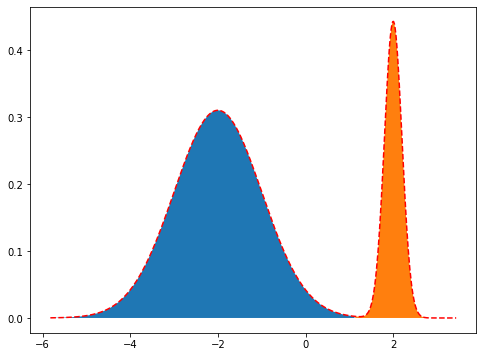

In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

loc1, scale1, size1 = (-2, 1, 175)
loc2, scale2, size2 = (2, 0.2, 50)

x2 = np.concatenate([np.random.normal(loc=loc1, scale=scale1, size=size1),
                     np.random.normal(loc=loc2, scale=scale2, size=size2)])
x_eval = np.linspace(x2.min() - 1, x2.max() + 1, 500)
X_train = x_eval[:375]
X_test = x_eval[375:]

bimodal_pdf = (norm.pdf(x_eval, loc=loc1, scale=scale1) * float(size1) / x2.size
               + norm.pdf(x_eval, loc=loc2, scale=scale2) * float(size2) / x2.size)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.plot(x_eval, bimodal_pdf, 'r--', label="Actual PDF")
ax.fill_between(X_train, bimodal_pdf[:375])
ax.fill_between(X_test, bimodal_pdf[375:])

ax.plot()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2)                 4         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3         
Total params: 7
Trainable params: 7
Non-trainable params: 0
_________________________________________________________________


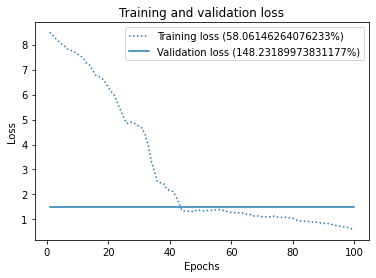

In [2]:
def plot_loss(history):
    fig, axis = plt.subplots()
    color = next(axis._get_lines.prop_cycler)['color']
    
    loss = history['loss']
    val_loss = history['val_loss']

    epochs = range(1, len(loss) + 1)

    axis.plot(epochs,
              loss,
              color=color,
              linestyle='dotted',
              label='Training loss ({}%)'.format(np.format_float_positional(min(loss)*100)))
    axis.plot(epochs,
              val_loss,
              color=color,
              label='Validation loss ({}%)'.format(np.format_float_positional(min(val_loss)*100)))
    axis.set_title('Training and validation loss')
    axis.set_xlabel('Epochs')
    axis.set_ylabel('Loss')
    axis.legend()

    plt.show()

# Basic NN
from tensorflow.keras import models, layers

def get_model():
    model = models.Sequential()
    model.add(layers.Dense(2, activation='linear', input_shape=(1,)))
    model.add(layers.Dense(1, activation='linear'))
    model.summary()
    model.compile(loss='binary_crossentropy', metrics=['accuracy'])
    return model

x_train = np.array([np.array(x) for x in X_train])
y_train = bimodal_pdf[:375]
x_val = np.array([np.array(x) for x in X_test])
y_val = bimodal_pdf[375:]

history = get_model().fit(x_train,
                          y_train,
                          validation_data=(x_val, y_val),
                          epochs=100,
                          verbose=0).history

plot_loss(history)

In [3]:
from adapt.feature_based import CORAL
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.losses import binary_crossentropy as loss

class SavePrediction(Callback):
    """Callback which stores predicted labels in history at each epoch."""
    def __init__(self, X_train, y_train, X_val, y_val):
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        self.history = {
            'loss': [],
            'val_loss': []
        }
        super().__init__()

    def on_epoch_end(self, batch, logs={}):
        """Applied at the end of each epoch"""
        y_train_pred = self.model.predict_on_batch(self.X_train).ravel()
        y_val_pred = self.model.predict_on_batch(self.X_val).ravel()
        self.history['loss'].append(np.mean(loss(self.y_train, y_train_pred)))
        self.history['val_loss'].append(np.mean(loss(self.y_val, y_val_pred)))

model = CORAL(get_model())

save_preds = SavePrediction(x_train, y_train, x_val, y_val)
model.fit(x_train,
          y_train,
          x_train,
          callbacks=[save_preds], 
          epochs=100,
          verbose=0)

plot_loss(save_preds.history)

ModuleNotFoundError: No module named 'adapt'

In [4]:
from wilds import get_dataset
import torchvision.transforms as transforms

# Load the full dataset
dataset = get_dataset(dataset='iwildcam', download=False)

transformations = transforms.Compose([transforms.Resize((150,150)),
                                      transforms.ToTensor()])
train_data = dataset.get_subset('train', transform=transformations)
test_data = dataset.get_subset('test', transform=transformations)

X_train = np.array([d[0].numpy() for d in train_data]).reshape((len(X_train), 150, 150, 3))
y_train = np.array([d[1] for d in train_data])
X_test = np.array([d[0].numpy() for d in test_data]).reshape((len(X_test), 150, 150, 3))
y_test = np.array([d[1] for d in test_data])

ModuleNotFoundError: No module named 'wilds'

In [5]:
from tensorflow.keras import losses, optimizers
from tensorflow import keras

def get_tensor_model():
    # classes_num = 182
    # pool_size = 4
    # lr = 0.001
    # nb_filters1 = 32
    # nb_filters2 = 64
    # conv1_size = 3
    # conv2_size = 2
    # img_width, img_height = 150, 150
    # model = models.Sequential()
    # model.add(layers.Convolution2D(nb_filters1, conv1_size, conv1_size,
    #                                padding='same',
    #                                input_shape=(3, img_width, img_height),
    #                                data_format='channels_first'))
    # model.add(layers.Activation("relu"))
    # model.add(layers.MaxPooling2D(pool_size=(pool_size, pool_size)))

    # model.add(layers.Convolution2D(nb_filters2, conv2_size, conv2_size,
    #                                padding='same'))
    # model.add(layers.Activation("relu"))
    # model.add(layers.MaxPooling2D(pool_size=(pool_size, pool_size),
    #                               padding='same'))
    # model.add(layers.Flatten())
    # model.add(layers.Dense(256))
    # model.add(layers.Activation("relu"))
    # model.add(layers.Dropout(0.5))
    # model.add(layers.Dense(1, activation='softmax'))

    # model.summary()

    # model.compile(loss='categorical_crossentropy',
    #             optimizer=optimizers.RMSprop(lr=lr),
    #             metrics=['accuracy'])
    input_shape = (150, 150, 3)
    classes_num = 182
    inputs = keras.Input(shape=input_shape)
    # x = layers.Rescaling(1.0 / 255)(inputs)  # Rescale inputs
    outputs = keras.applications.ResNet50(  # Add the rest of the model
        weights=None, input_shape=input_shape, classes=classes_num
    )(inputs)
    model = keras.Model(inputs, outputs)
    model.summary()
    model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")
    return model

history = get_tensor_model().fit(X_train[:100], y_train[:100],
                                 validation_data=(X_test[:100], y_test[:100]),
                                 epochs=100,
                                 verbose=1).history

plot_loss(history)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 182)               23960630  
Total params: 23,960,630
Trainable params: 23,907,510
Non-trainable params: 53,120
_________________________________________________________________


NameError: name 'y_test' is not defined

12/10/21 Notes (John):

* Last time we talked: key point is "why do I need these datasets specifically? Can I just use a toy dataset like MNIST?"
* Paper cites examples like "Invariant risk minimization" of people already doing that, which is what makes this paper novel
* What I've tried:
    * scatterplot example using Empirical Risk Minimization vs. using CORAL
    * iwildcam using custom small NN, iwildcam using ResNet50. Results are only relatively useful when using the big pre-trained model.
* Idea:
    * Play around with architectures? Perhaps the effects differ depending on how many nodes/params
* Feedback:
    * More vs less separated in CORAL
    * Check different dimensionalities
    * Visualize separations of classes
    * Many clusters, high decision boundary
    * Transform the wilds datasets (downsample, saturate, etc.)
    * Datasets don't capture every possible domain shift
    * PCA. TSNE, Clusters

12/10/21 Notes 2:

#### how to satisfy project requirements about code:

1.  At least one clear working pedagogical example demonstrating the problem the paper is claiming to solve. 
2. Demonstration on at least one instance that your implementation solves the problem.
   - 1 and 2 can be satisfied together by: implement and demonstrate the key idea, key problem in WILDS

3. At lease a bare bones implementation of the model/algorithm/solution (in some cases, you may be able to make assumptions to simplify the model/algorithm/solution with the approval of your instructor) 
   - code our bare bones implementation (in simplified settings if needed)

        
4. Demonstration on at least one instance the failure mode of the model/algorithm/solution, with an explanation for why failure occurred (is the dataset too large? Did you choose a bad hyper parameter?). The point of this is to point out edge cases to the user.
   - show a situation where WILDS is no better than toy data


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=80cb1556-c762-4c6a-89b8-6410c844af03' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>